Download RetinaNet library:

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 37.27 MiB/s, done.
Resolving deltas: 100% (4201/4201), done.


Install the library:

In [2]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168016 sha256=cc71c52e69f41d566eff24e55472a56e5ca1d625fde0b2cf08e3d89d4d3ae961
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=d746f63b3139b49af395ea33fad4ee006a6d47cf24f3b9b86c1945df9b7d8a47
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -

Import essential libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib
import os
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

Download a pretrained network from https://github.com/fizyr/keras-retinanet/releases:

In [5]:
urllib.request.urlretrieve(
    'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5',
    'pretrained_model.h5')

('pretrained_model.h5', <http.client.HTTPMessage at 0x7f9f92aef250>)

Loading the pretrained model:

In [6]:
model = models.load_model('pretrained_model.h5')

In [7]:
model.summary()

Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________________________________

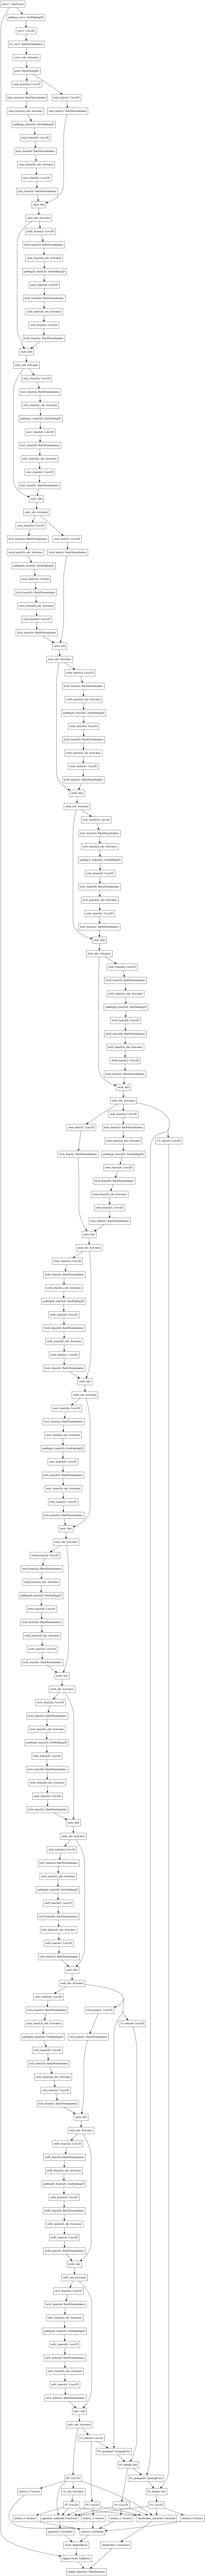

In [8]:
from tensorflow import keras
keras.utils.plot_model(model)

The COCO's dataset class names:

In [9]:
class_names = ['person',
              'bicycle',
              'car',
              'motorcycle',
              'airplane',
              'bus',
              'train',
              'truck',
              'boat',
              'traffic light',
              'fire hydrant',
              'stop sign',
              'parking meter',
              'bench',
              'bird',
              'cat',
              'dog',
              'horse',
              'sheep',
              'cow',
              'elephant',
              'bear',
              'zebra',
              'giraffe',
              'backpack',
              'umbrella',
              'handbag',
              'tie',
              'suitcase',
              'frisbee',
              'skis',
              'snowboard',
              'sports ball',
              'kite',
              'baseball bat',
              'baseball glove',
              'skateboard',
              'surfboard',
              'tennis racket',
              'bottle',
              'wine glass',
              'cup',
              'fork',
              'knife',
              'spoon',
              'bowl',
              'banana',
              'apple',
              'sandwich',
              'orange',
              'broccoli',
              'carrot',
              'hot dog',
              'pizza',
              'donut',
              'cake',
              'chair',
              'couch',
              'potted plant',
              'bed',
              'dining table',
              'toilet',
              'tv',
              'laptop',
              'mouse',
              'remote',
              'keyboard',
              'cell phone',
              'microwave',
              'oven',
              'toaster',
              'sink',
              'refrigerator',
              'book',
              'clock',
              'vase',
              'scissors',
              'teddy bear',
              'hair drier',
              'toothbrush']

Defining a function for the main purpose:

In [10]:
def show_image_with_predictions(img_path, threshold=0.6):
  im = np.array(Image.open(img_path))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

    class_name = class_names[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


Enlarge the output image:

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]

Authorize and ount the google drive:


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the images folder:

In [15]:
!unzip -uq "/content/drive/My Drive/datasets/handy/test_cases.zip" -d "/content/drive/My Drive/datasets/handy"

Doing the object detection:

im.shape: (1600, 2560, 3)


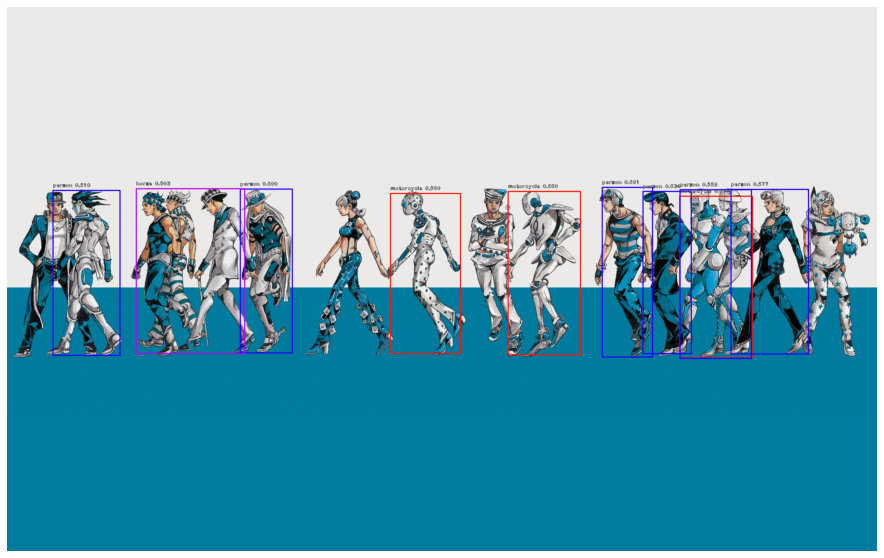

In [19]:
show_image_with_predictions('/content/drive/My Drive/datasets/handy/jojo.jpg', 0.5)